In [1]:
# general
import numpy as np
import pandas as pd
import verde as vd
import harmonica as hm
from scipy import interpolate
import xarray as xr
import cmocean
import geopandas as gpd
import shapely
from shapely.geometry import LineString
import multiprocessing as mp

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import animation

# io
from tqdm.auto import tqdm
import os
from copy import deepcopy
import xml.etree.ElementTree as ET
from pathlib import Path
import itertools

# geostatistics
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import pairwise_distances
import gstatsim as gsm
import skgstat as skg
from skgstat import models

# custom
from prisms import *
from rfgen import *
from bouguer import *
from utilities import *
from diagnostics import *

## paths

In [2]:
# gravity paths
OIB_path = Path('raw_data/OIB')
ITGC_path = Path('raw_data/K_Tinto_ITGC_2019/Thw_tera_pos_grav_share.XYZ')

# BedMachine v3 path
bm_path = Path('raw_data/bedmachine/BedMachineAntarctica-v3.nc')

# grounding zone path
gzone_path = Path('../fancy_plot/grounding_zone/Antarctic_GZ_2018_v01.0.shp')

# Muto et al 2024 seismic
dotson_seismic_path = Path('raw_data/Dotson_seismic.csv')
teis_seismic_path = Path('raw_data/TEIS_seismic.csv')

if os.path.exists(Path('./processed_data')) == False:
    os.mkdir(Path('./processed_data'))

In [3]:
# region
region = [-1.6805e6, -1.4205e6, -7.205e5, -3.505e5]

# resolution
res = 2000

# Gravity

In [4]:
itgc = pd.read_table(ITGC_path, header=5, sep=',', na_values=['*'])
itgc = itgc[['Lat_deg', 'Lon_deg', 'x', 'y', 'FAA_spl_2_ICEBRIDGE', 'Hght_GRS80']]
itgc.columns = ['lat', 'lon', 'x', 'y', 'faa', 'height']
itgc = itgc.dropna().reset_index(drop=True)

tables = []
with os.scandir(OIB_path) as it:
    for entry in it:
        if entry.is_dir() == True:
            fnames= os.listdir(OIB_path/entry.name)
            for fname in fnames:
                if fname.endswith('.xml'):
                    tree = ET.parse(OIB_path/entry.name/fname)
                    root = tree.getroot()
                    # print(fname + '\t' + root[2][7][1].text)
                if fname.endswith('.txt'):
                    path = OIB_path/entry.name/fname
                    tmp = pd.read_table(path, header=69, delim_whitespace=True)
                    header = tmp.columns[1:]
                    tmp = tmp.drop(columns=['FLTENVIRO'])
                    tmp.columns = header
                    tables.append(tmp)

oib = pd.concat(tables, axis=0)
oib = oib[['LAT', 'LONG', 'PSX', 'PSY', 'FAG070', 'FAG100', 'FAG140', 'FLTENVIRO', 'WGSHGT']]
oib.columns = ['lat', 'lon', 'x', 'y', 'faa70', 'faa100', 'faa140', 'flag', 'height']
oib = oib[oib.flag == 0]
oib = oib.drop(columns=['flag']).reset_index(drop=True)

# combine itgc and obi
oib = oib.drop(columns=['faa100', 'faa140'])
oib = oib.rename(columns={'faa70' : 'faa'})

oib_cat_1 = np.ones(oib.shape[0])
oib_cat_2 = np.zeros(itgc.shape[0])

oib['oib'] = oib_cat_1
itgc['oib'] = oib_cat_2

oib = oib[['x', 'y', 'lat', 'lon', 'height', 'faa', 'oib']]
itgc = itgc[['x', 'y', 'lat', 'lon', 'height', 'faa', 'oib']]

grav = pd.concat([oib, itgc]).reset_index(drop=True)

# trim data to AOI with padding
region_pad = vd.pad_region(region, -20e3)
grav = grav[(grav.x > region_pad[0]) & (grav.x < region_pad[1]) & (grav.y > region_pad[2]) 
              & (grav.y < region_pad[3])]

# only take points less than 1200 m
grav = grav[grav.height < 1200].reset_index(drop=True)

In [5]:
print(f'gravity shape: {grav.shape}')
grav.head()

gravity shape: (303429, 7)


,x,y,lat,lon,height,faa,oib
0,-1660466.10,-635658.23,-73.741659,-110.947803,613.26,-6.88,1.0
1,-1660409.49,-635708.25,-73.741975,-110.949961,610.59,-6.84,1.0
2,-1660352.89,-635758.24,-73.742290,-110.952117,607.93,-6.81,1.0
3,-1660296.30,-635808.18,-73.742606,-110.954273,605.27,-6.77,1.0
4,-1660239.72,-635858.10,-73.742922,-110.956427,602.60,-6.74,1.0


In [6]:
grav.to_csv(Path('processed_data/grav_combined.csv'), index=False)

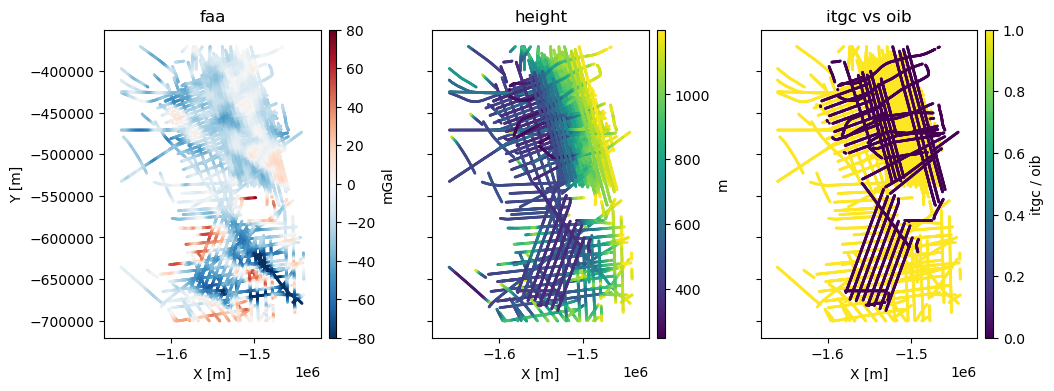

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)

ax = axs[0]
im = ax.scatter(grav.x[::10], grav.y[::10], c=grav.faa[::10], s=1, vmin=-80, vmax=80, cmap='RdBu_r')
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')
ax.set_xlim(region[0], region[1])
ax.set_ylim(region[2], region[3])
ax.set_title('faa')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

ax = axs[1]
im = ax.scatter(grav.x[::10], grav.y[::10], c=grav.height[::10], s=1)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
ax.set_xlim(region[0], region[1])
ax.set_ylim(region[2], region[3])
ax.set_title('height')
ax.set_xlabel('X [m]')

ax = axs[2]
im = ax.scatter(grav.x[::10], grav.y[::10], c=grav.oib[::10], s=1)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='itgc / oib')
ax.set_xlim(region[0], region[1])
ax.set_ylim(region[2], region[3])
ax.set_title('itgc vs oib')
ax.set_xlabel('X [m]')

plt.show()

# Equivalent sources for leveling

In [8]:
dampings = [1, 10, 100, 1000]
depths = [1e3, 3e3, 4e3, 5e3]

In [9]:
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))

Number of combinations: 16


### cross validation to find best damping and depth

In [10]:
# %%time

# # Gradient Boosted Equivalent sources
# equivalent_sources = hm.EquivalentSourcesGB(window_size=20e3)

# # Use downsampled data since so dense
# coordinates = (grav.x[::10], grav.y[::10], grav.height[::10])

# scores = []
# for params in tqdm(parameter_sets):
#     equivalent_sources.set_params(**params)
#     score = np.mean(
#         vd.cross_val_score(
#             equivalent_sources,
#             coordinates,
#             grav.faa[::10],
#         )
#     )
#     scores.append(score)
# scores

In [11]:
# best = np.argmax(scores)
# print("Best score:", scores[best])
# print("Best parameters:", parameter_sets[best])

### Best parameters are damping of 1 and depth of 3000

In [12]:
pred_coords = (grav.x, grav.y, np.full(grav.x.size, 1200))
coordinates = (grav.x[::10], grav.y[::10], grav.height[::10])

# use parameters from cross validation
# equivalent_sources = hm.EquivalentSourcesGB(**parameter_sets[best], window_size=20e3)

equivalent_sources = hm.EquivalentSourcesGB(damping=1, depth=3000, window_size=20e3)
equivalent_sources.fit(coordinates, grav.faa[::10])
leveled = equivalent_sources.predict(pred_coords)

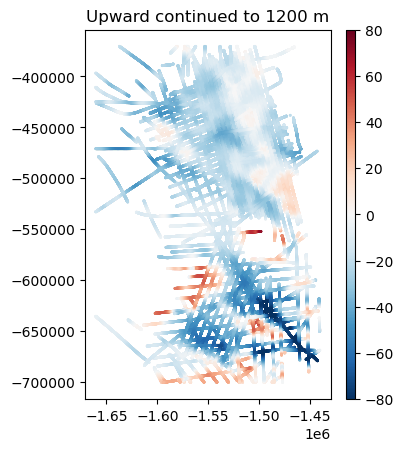

In [13]:
plt.scatter(grav.x, grav.y, c=leveled, s=1, vmin=-80, vmax=80, cmap='RdBu_r')
plt.axis('scaled')
plt.colorbar(pad=0.03, aspect=40)
plt.title('Upward continued to 1200 m')
ax.set_xlim(region[0], region[1])
ax.set_ylim(region[2], region[3])
#plt.savefig(Path('figures/upward_1200m.png'), dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# load grounding zone
gzone = gpd.read_file(gzone_path)

# Load BedMachine v3

In [15]:
grid = xr.open_dataset(bm_path)

# trim around padded region for coarsening
# the grid will be coarsed to the region
region_pad = vd.pad_region(region, 8000)

x_trim = (grid.x > region_pad[0]) & (grid.x < region_pad[1])
y_trim = (grid.y > region_pad[2]) & (grid.y < region_pad[3])

grid = grid.sel(x=x_trim, y=y_trim)

xx, yy = np.meshgrid(grid.x, grid.y)

## Enforce pinning points from grounding zone

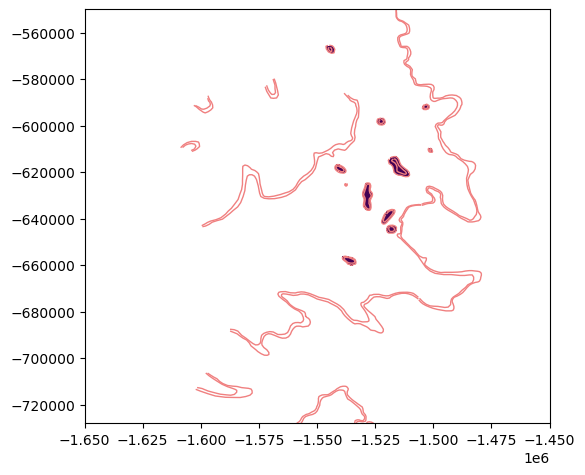

In [16]:
points = shapely.points(xx.ravel(), yy.ravel())
gdf = gpd.GeoDataFrame(geometry=points, crs='EPSG:3031')

lines = gzone[(gzone.Name=='Crosson') & (gzone.Type=='EIR')]['geometry'].explode(index_parts=False).reset_index(drop=True)

bad_polys = [(-1541821.1514367897, -617086.229281446),(-1539735.6732108742, -618056.6993469709)]

new = []
for line in lines:
    xy = list(line.coords)
    
    if xy[0] == xy[-1]:
        new.append(line)
    # bad ones
    elif xy[0] in bad_polys:
        xy = xy[:-2]
        xy.append(xy[0])
        new_line = LineString(xy)
        new.append(new_line)
    else:
        xy.append(xy[0])
        new_line = LineString(xy)
        new.append(new_line)

poly = shapely.ops.polygonize(new)

islands = gpd.GeoDataFrame(geometry=list(poly), crs='EPSG:3031')

intersect_gzone = gpd.sjoin(left_df=gdf[['geometry']], right_df=islands, how='inner')

xs = intersect_gzone.geometry.x.values
ys = intersect_gzone.geometry.y.values

mask = xy_into_grid(grid, (xs, ys), np.ones(xs.size), fill=np.nan, xdim=0, ydim=1)

fig, ax = plt.subplots(figsize=(6,8))
ax.pcolormesh(grid.x, grid.y, mask)
gzone.plot(facecolor='none', edgecolor='lightcoral', ax=ax, linewidth=1)
ax.axis('scaled')
ax.set_xlim(-1.65e6, -1.45e6)
ax.set_ylim(grid.y.values.min(), -0.55e6)
plt.show()

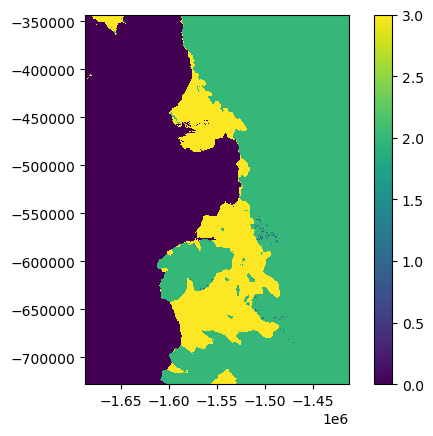

In [17]:
new_mask = np.where(mask==1, 2, grid.mask)

grid['mask'] = (('y', 'x'), new_mask)

plt.pcolormesh(grid.x, grid.y, grid.mask)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [18]:
# block reduce with median to desired resolution
reducer = vd.BlockReduce(np.median, spacing=res, region=region, adjust='region', 
                             center_coordinates=True)

coordinates = (xx, yy)

data = (
    grid['bed'].values,
    grid['surface'].values,
    grid['thickness'].values,
)

coords, data = reducer.filter(coordinates, data)

x_uniq = np.unique(coords[0])
y_uniq = np.unique(coords[1])
xx_red, yy_red = np.meshgrid(x_uniq, y_uniq)

# use nearest point to predict categorical variables
kn = vd.KNeighbors(k=1)

cat_data = (
    grid['mask'].values,
    grid['geoid'].values,
    grid['source'].values,
    grid['dataid'].values,
    grid['errbed'].values
)
kn_preds = []
for i, cdata in enumerate(cat_data):
    kn.fit(coordinates, cdata)
    kn_preds.append(kn.predict(coords))

# make new xarray
ds = vd.make_xarray_grid(
    coordinates=(xx_red, yy_red), 
    data=(
        data[0].reshape(xx_red.shape), 
        data[1].reshape(xx_red.shape), 
        data[2].reshape(xx_red.shape), 
        kn_preds[0].reshape(xx_red.shape), 
        kn_preds[1].reshape(xx_red.shape), 
        kn_preds[2].reshape(xx_red.shape), 
        kn_preds[3].reshape(xx_red.shape), 
        kn_preds[4].reshape(xx_red.shape)),
    data_names=('bed', 'surface', 'thickness', 'mask', 'geoid', 'source', 'dataid', 'errbed'),
    dims=('y', 'x')
)

# make sure surface is 0 in open water
ds['surface'] = (('y', 'x'), np.where(ds.mask==0, 0, ds.surface))

# make sure thickness is 0 in open water and at exposed rock
ocean_rock_msk = (ds.mask==0)^(ds.mask==1)
ds['thickness'] = (('y', 'x'), np.where(ocean_rock_msk, 0, ds.thickness))

# make sure bed is equal to surface minus thickness under grounded ice
ds['bed'] = (('y', 'x'), np.where(ds.mask==2, ds.surface-ds.thickness, ds.bed))

# make sure surface is equal to bed at exposed rock
ds['bed'] = (('y', 'x'), np.where(ds.mask==1, ds.surface, ds.bed))

# make sure bed not above ice in ice shelf
bed_above_ice_bottom = np.where(ds.bed > (ds.surface-ds.thickness), True, False)
ds['bed'] = (('y', 'x'), np.where(bed_above_ice_bottom, ds.surface-ds.thickness, ds.bed))

# make mask grounded ice where bed was above ice bottom
ds['mask'] = (('y', 'x'), np.where(bed_above_ice_bottom, 2, ds.mask))

# reference elevations to WGS84
ds['bed'] += ds['geoid']
ds['surface'] += ds['geoid']

ds

<xarray.Dataset> Size: 1MB
Dimensions:    (y: 185, x: 130)
Coordinates:
  * x          (x) float64 1kB -1.68e+06 -1.678e+06 ... -1.424e+06 -1.422e+06
  * y          (y) float64 1kB -7.195e+05 -7.175e+05 ... -3.535e+05 -3.515e+05
Data variables:
    bed        (y, x) float32 96kB -522.2 -532.5 -540.4 ... -858.8 -1.101e+03
    surface    (y, x) float32 96kB -33.0 -33.0 -33.0 ... 1.122e+03 1.145e+03
    thickness  (y, x) float32 96kB 0.0 0.0 0.0 ... 1.973e+03 1.981e+03 2.246e+03
    mask       (y, x) float64 192kB 0.0 0.0 0.0 0.0 0.0 ... 2.0 2.0 2.0 2.0 2.0
    geoid      (y, x) float64 192kB -33.0 -33.0 -33.0 ... -28.0 -28.0 -28.0
    source     (y, x) float64 192kB 10.0 3.0 10.0 3.0 3.0 ... 5.0 5.0 5.0 5.0
    dataid     (y, x) float64 192kB 10.0 0.0 10.0 0.0 0.0 ... 2.0 0.0 0.0 0.0
    errbed     (y, x) float32 96kB 10.0 nan 10.0 nan nan ... 31.0 30.0 36.0 32.0

# Add Muto et al., 2024 seismic sounding conditioning data

In [19]:
muto = pd.read_csv(dotson_seismic_path)
muto.head()

,%StationID,Latitude,Longitude,PSX,PSY,surface_elevation_WGS84,ice_botom_elevation,sea_floor_elevation,water_column_thickness
0,1165,-74.871178,-112.202392,-1.530452e+06,-624640.392452,25.017,-354.415,-704.507,350.092
1,1197,-74.807775,-111.739325,-1.541958e+06,-614845.858268,41.401,-498.513,-1024.062,525.549
2,1199,-74.821613,-111.827818,-1.539587e+06,-616658.097676,29.092,-429.390,-1057.876,628.486
3,1201,-74.831066,-111.924561,-1.537574e+06,-618866.739161,36.041,-467.653,-905.570,437.917
4,1204,-74.839222,-112.023437,-1.535669e+06,-621181.272228,35.937,-470.431,-1066.466,596.035


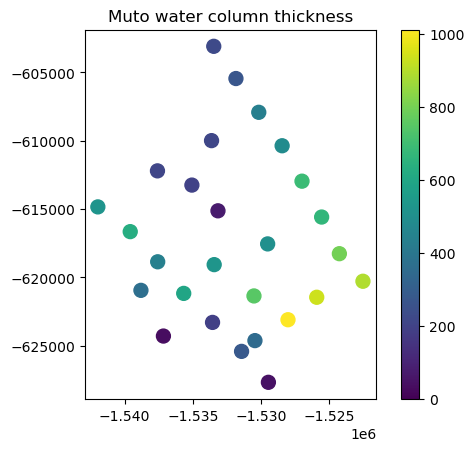

In [20]:
fig, ax = plt.subplots()
im = ax.scatter(muto['PSX'], muto['PSY'], c=muto['water_column_thickness'], s=100, vmin=0)
ax.axis('scaled')
ax.set_title('Muto water column thickness')
plt.colorbar(im, ax=ax)
plt.show()

In [21]:
imin = np.rint(0.2*ds.y.size).astype(int)
imax = np.rint(0.38*ds.y.size).astype(int)
jmin = np.rint(0.48*ds.x.size).astype(int)
jmax = np.rint(0.68*ds.x.size).astype(int)

vmin = -1600
vmax = 0

east_muto_trim = ds.x.values[jmin:jmax].copy()
north_muto_trim = ds.y.values[imin:imax].copy()
#mean_trim = np.mean(last_iter, axis=0)[imin:imax,jmin:jmax]
bm_trim = ds.bed.values[imin:imax,jmin:jmax]

imin, imax, jmin, jmax

(np.int64(37), np.int64(70), np.int64(62), np.int64(88))

In [22]:
spline = vd.SplineCV(dampings=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3])
data_coords = (muto['PSX'].values, muto['PSY'].values)
spline.fit(data_coords, muto['sea_floor_elevation'])
print(f'best damping: {spline.damping_}')

xx, yy = np.meshgrid(ds.x.values, ds.y.values)
pred_coords = (xx, yy)
preds = spline.predict(pred_coords)
msk1 = vd.convexhull_mask(data_coords, pred_coords)
msk2 = vd.distance_mask(data_coords, 2e3, pred_coords)
msk_dotson = np.any(np.stack([msk1, msk2]), axis=0)
preds = np.where(msk_dotson, preds, np.nan).reshape(xx.shape)

best damping: 0.0001


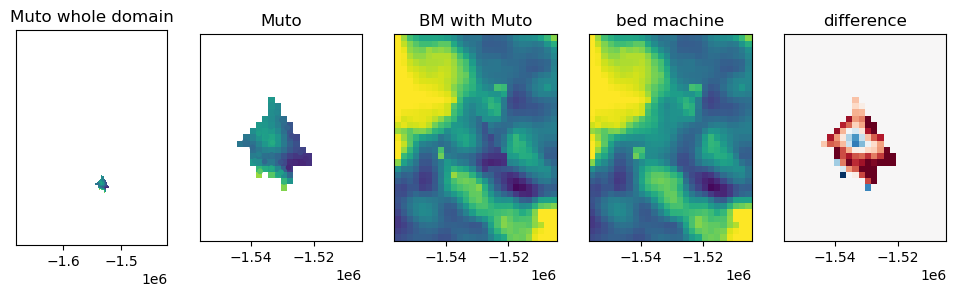

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(12,4), gridspec_kw={'width_ratios':[0.93,1,1,1, 1]})

ax = axs[0]
ax.pcolormesh(ds.x, ds.y, preds, vmin=vmin, vmax=vmax)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('Muto whole domain')

ax = axs[1]
ax.pcolormesh(east_muto_trim, north_muto_trim, preds[imin:imax,jmin:jmax], vmin=vmin, vmax=vmax)
ax.scatter(muto['PSX'], muto['PSY'], c=muto['sea_floor_elevation'], s=10, cmap='viridis', vmin=vmin, vmax=vmax)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('Muto')

ax = axs[2]
ax.pcolormesh(east_muto_trim, north_muto_trim, bm_trim, vmin=vmin, vmax=vmax)
ax.pcolormesh(east_muto_trim, north_muto_trim, preds[imin:imax,jmin:jmax], vmin=vmin, vmax=vmax)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('BM with Muto')

ax = axs[3]
ax.pcolormesh(east_muto_trim, north_muto_trim, bm_trim, vmin=vmin, vmax=vmax)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('bed machine')

ax = axs[4]
ax.pcolormesh(east_muto_trim, north_muto_trim, bm_trim-np.where(np.isnan(preds[imin:imax,jmin:jmax]), bm_trim, preds[imin:imax,jmin:jmax]), cmap='RdBu_r', vmin=-200, vmax=200)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('difference')
plt.show()

In [24]:
muto_teis = pd.read_csv(teis_seismic_path)
muto_teis.head()

,%StationID,Latitude,Longitude,PSX,PSY,surface_elevation_WGS84,ice_botom_elevation,sea_floor_elevation,water_column_thickness
0,1052,-75.045046,-105.597770,-1.573640e+06,-439302.049329,23.789,-293.691,-826.797,533.106
1,1054,-75.054316,-105.603176,-1.572612e+06,-439175.098032,25.768,-308.097,-689.142,381.045
2,1056,-75.055653,-105.565914,-1.572755e+06,-438112.642694,25.316,-292.295,-748.404,456.109
3,1058,-75.046776,-105.561639,-1.573732e+06,-438258.312787,25.415,-287.564,-729.608,442.044
4,1062,-75.038326,-105.523860,-1.574920e+06,-437470.338215,26.842,-281.388,-819.505,538.117


In [25]:
imin = np.rint(0.66*ds.y.size).astype(int)
imax = np.rint(0.84*ds.y.size).astype(int)
jmin = np.rint(0.3*ds.x.size).astype(int)
jmax = np.rint(0.5*ds.x.size).astype(int)

vmin = -1600
vmax = 0

east_muto_trim_teis = ds.x.values[jmin:jmax].copy()
north_muto_trim_teis = ds.y.values[imin:imax].copy()
#mean_trim = np.mean(last_iter, axis=0)[imin:imax,jmin:jmax]
bm_trim_teis = ds.bed.values[imin:imax,jmin:jmax]

imin, imax, jmin, jmax

(np.int64(122), np.int64(155), np.int64(39), np.int64(65))

In [26]:
spline = vd.SplineCV(dampings=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3])
data_coords = (muto_teis['PSX'].values, muto_teis['PSY'].values)
spline.fit(data_coords, muto_teis['sea_floor_elevation'])
print(f'best damping: {spline.damping_}')

xx, yy = np.meshgrid(ds.x.values, ds.y.values)
pred_coords = (xx, yy)
preds_teis = spline.predict(pred_coords)
msk1 = vd.convexhull_mask(data_coords, pred_coords)
msk2 = vd.distance_mask(data_coords, 2e3, pred_coords)
msk_teis = np.any(np.stack([msk1, msk2]), axis=0)
preds_teis = np.where(msk_teis, preds_teis, np.nan).reshape(xx.shape)

best damping: 0.001


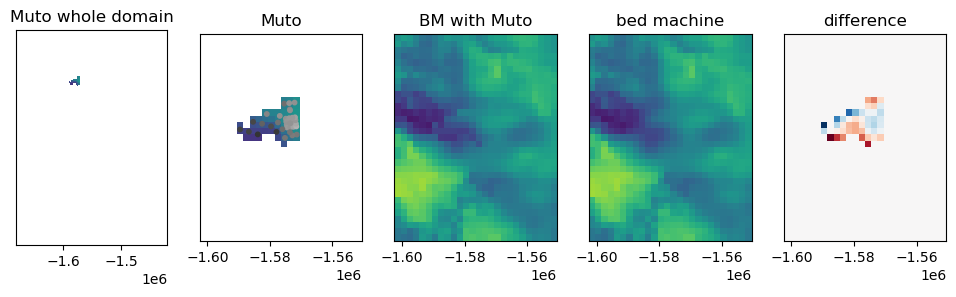

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(12,4), gridspec_kw={'width_ratios':[0.93,1,1,1, 1]})

ax = axs[0]
ax.pcolormesh(ds.x, ds.y, preds_teis, vmin=vmin, vmax=vmax)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('Muto whole domain')

ax = axs[1]
ax.pcolormesh(east_muto_trim_teis, north_muto_trim_teis, preds_teis[imin:imax,jmin:jmax], vmin=vmin, vmax=vmax)
ax.scatter(muto_teis['PSX'], muto_teis['PSY'], c=muto_teis['sea_floor_elevation'], s=10, cmap='Greys_r', vmin=vmin, vmax=vmax)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('Muto')

ax = axs[2]
ax.pcolormesh(east_muto_trim_teis, north_muto_trim_teis, bm_trim_teis, vmin=vmin, vmax=vmax)
ax.pcolormesh(east_muto_trim_teis, north_muto_trim_teis, preds_teis[imin:imax,jmin:jmax], vmin=vmin, vmax=vmax)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('BM with Muto')

ax = axs[3]
ax.pcolormesh(east_muto_trim_teis, north_muto_trim_teis, bm_trim_teis, vmin=vmin, vmax=vmax)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('bed machine')

ax = axs[4]
ax.pcolormesh(east_muto_trim_teis, north_muto_trim_teis, bm_trim_teis-np.where(np.isnan(preds_teis[imin:imax,jmin:jmax]), bm_trim_teis, 
                                                                               preds_teis[imin:imax,jmin:jmax]), cmap='RdBu_r', vmin=-200, vmax=200)
ax.axis('scaled')
ax.set_yticks([])
ax.set_title('difference')
plt.show()

In [28]:
msk = np.any([msk_dotson, msk_teis], axis=0)
preds_combine = np.where(np.isnan(preds), 0, preds) + np.where(np.isnan(preds_teis), 0, preds_teis)
preds_combine = np.where(preds_combine==0, np.nan, preds_combine)

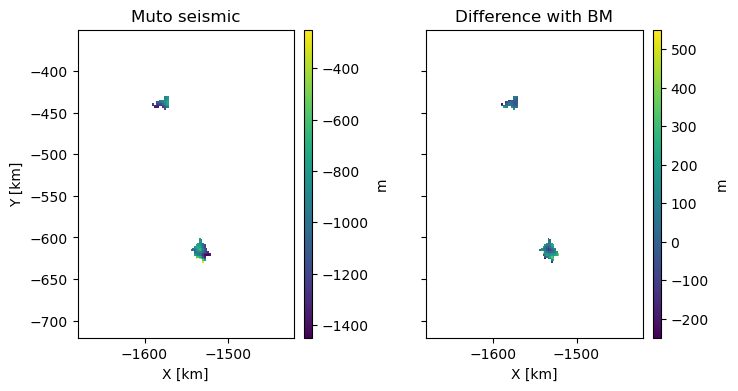

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True, gridspec_kw=dict(wspace=0.))
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, preds_combine)
ax.axis('scaled')
ax.set_title('Muto seismic')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, ds.bed-preds_combine)
ax.axis('scaled')
ax.set_title('Difference with BM')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

In [30]:
ds['bed_no_muto'] = (('y', 'x'), ds.bed.values)
ds['bed'] = (('y', 'x'), np.where(np.isnan(preds_combine), ds.bed, preds_combine))
ds['source'] = (('y', 'x'), np.where(np.isnan(preds_combine), ds.source, 7))

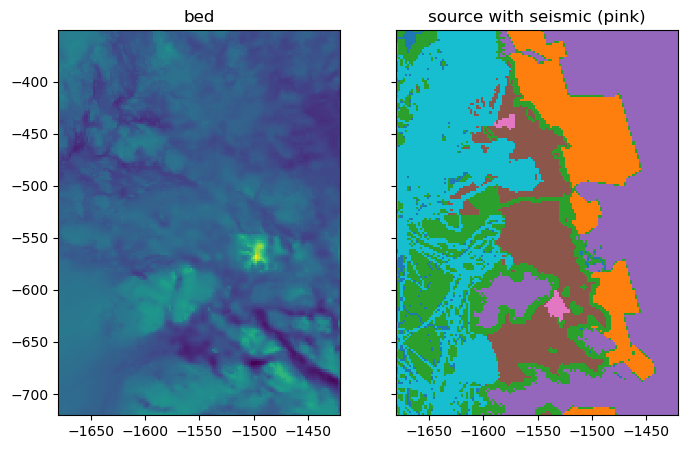

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharey=True)
ax = axs[0]
ax.pcolormesh(ds.x/1000, ds.y/1000, ds.bed)
ax.set_title('bed')
ax = axs[1]
ax.pcolormesh(ds.x/1000, ds.y/1000, ds.source, cmap='tab10')
ax.set_title('source with seismic (pink)')
plt.show()

# Upward continue onto grid

In [32]:
xx, yy = np.meshgrid(ds.x, ds.y)
pred_coords = (xx.flatten(), yy.flatten(), np.full(xx.flatten().size, 1200))

leveled_grid = equivalent_sources.predict(pred_coords)

In [33]:
grav_msk_grid = vd.distance_mask(
    data_coordinates = (grav.x[::10], grav.y[::10], grav.height[::10]),
    maxdist = 4000,
    coordinates = (pred_coords[0], pred_coords[1])
)
x_grid = pred_coords[0][grav_msk_grid==True]
y_grid = pred_coords[1][grav_msk_grid==True]
leveled_grid_msk = leveled_grid[grav_msk_grid==True]

In [34]:
grav = pd.DataFrame({'x' : x_grid, 'y' : y_grid, 'faa' : leveled_grid_msk, 'height' : np.full(x_grid.size, 1200)})
print(f'gridded gravity shape: {grav.shape}')
grav.head()

gridded gravity shape: (12396, 4)


,x,y,faa,height
0,-1597500.0,-703500.0,13.674402,1200
1,-1595500.0,-703500.0,17.767093,1200
2,-1593500.0,-703500.0,21.133231,1200
3,-1591500.0,-703500.0,22.951026,1200
4,-1589500.0,-703500.0,23.476513,1200


In [35]:
# create inversion mask, excluding ice shelf at top and bottom
rules = np.stack([ds.source.values == 6, xx > -1.64e6, yy > -7e5])
iceshelf_msk = np.all(rules, axis=0)

# use 4 km padding to include some interpolation
inv_msk = vd.distance_mask(
    data_coordinates = (xx[iceshelf_msk==True], yy[iceshelf_msk==True]),
    maxdist = 4000,
    coordinates = (xx, yy)
)
inv_msk = np.where(ds.source==7, False, inv_msk)
inv_msk = np.where(ds.source==10, False, inv_msk)

# remove grounded ice
inv_msk = np.where(inv_msk & (ds.mask!=2), True, False)

# assign inversion masks, second one excludes the seismic
ds['inv_msk'] = (('y', 'x'), inv_msk)
ds['inv_no_muto'] = (('y', 'x'), np.any([ds.inv_msk, msk], axis=0))

grav_msk = vd.distance_mask(
    data_coordinates = (xx[iceshelf_msk==True], yy[iceshelf_msk==True]),
    maxdist = 4000,
    coordinates = (grav.x, grav.y)
)

grav['msk'] = grav_msk

kn = vd.KNeighbors(k=1)
kn.fit((xx, yy), ds.inv_msk.values)
grav_inv_msk = kn.predict((grav.x, grav.y))
grav['inv_msk'] = grav_inv_msk

# padded inversion domain mask
inv_pad = vd.distance_mask(
    data_coordinates = (xx[inv_msk==True], yy[inv_msk==True]),
    coordinates = (grav.x, grav.y),
    maxdist = 10e3
)
grav['inv_pad'] = inv_pad

# remove ice shelves from top and bottom
inv_msk = np.all([
    inv_msk==True,
    (yy - yy.min()) > 20e3,
    (yy.max() - yy) > 20e3
], axis=0)

# add erroneous interpolation in middle
bad_interp = np.all([xx > -1.585e6, xx < -1.525e6, yy > -0.525e6, yy < -0.51e6], axis=0)
inv_msk[bad_interp==True] = True

# add resolution attribute
ds = ds.assign_attrs(res=res)

# make sure surface is 0 in open water
ds['surface'] = (('y', 'x'), np.where(ds.mask==0, 0, ds.surface))

# make sure thickness is 0 in open water and at exposed rock
ocean_rock_msk = (ds.mask==0)^(ds.mask==1)
ds['thickness'] = (('y', 'x'), np.where(ocean_rock_msk, 0, ds.thickness))

# make sure bed is equal to surface minus thickness under grounded ice
ds['bed'] = (('y', 'x'), np.where(ds.mask==2, ds.surface-ds.thickness, ds.bed))

# make sure surface is equal to bed at exposed rock
ds['bed'] = (('y', 'x'), np.where(ds.mask==1, ds.surface, ds.bed))

# make sure bed not above ice in ice shelf
bed_above_ice_bottom = np.where(ds.bed > (ds.surface-ds.thickness), True, False)
ds['bed'] = (('y', 'x'), np.where(bed_above_ice_bottom, ds.surface-ds.thickness, ds.bed))

# make mask grounded ice where bed was above ice bottom
ds['mask'] = (('y', 'x'), np.where(bed_above_ice_bottom, 2, ds.mask))

# save xarray Dataset
ds.to_netcdf(Path(f'processed_data/xr_{res}.nc'))

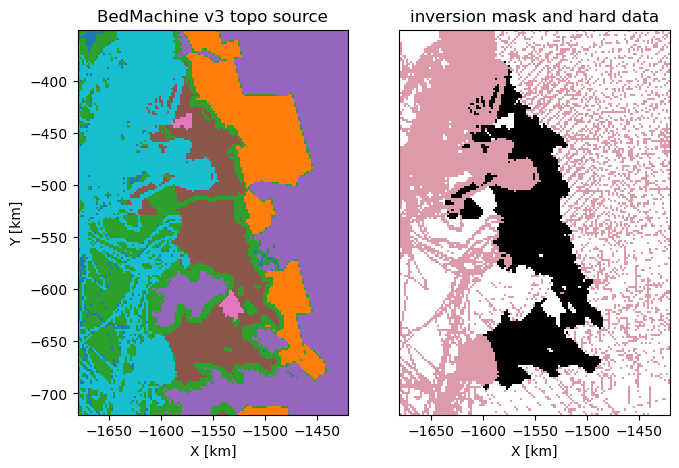

In [36]:
fig = plt.figure(figsize=(8,5))

grid = GridSpec(1, 2, wspace=0.08)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])

ax1.pcolormesh(ds.x/1000, ds.y/1000, ds.source, cmap='tab10')
ax1.set_title('BedMachine v3 topo source')
ax1.set_ylabel('Y [km]')
ax1.set_xlabel('X [km]')
ax1.axis('scaled')

ax2.pcolormesh(ds.x/1000, ds.y/1000, ds.inv_msk, cmap='gray_r')
ax2.pcolormesh(ds.x/1000, ds.y/1000, np.where(ds.dataid.data>0, 1, np.nan), cmap='inferno', 
               vmin=0, vmax=2, alpha=0.5)
ax2.set_title('inversion mask and hard data')
ax2.set_xlabel('X [km]')
ax2.axis('scaled')
ax2.set_yticks([])

plt.show()

In [37]:
xkm = ds.x/1000
ykm = ds.y/1000

In [38]:
grav_bm_grid = np.where(grav_msk_grid.reshape(ds.bed.shape), leveled_grid.reshape(ds.bed.shape), np.nan)

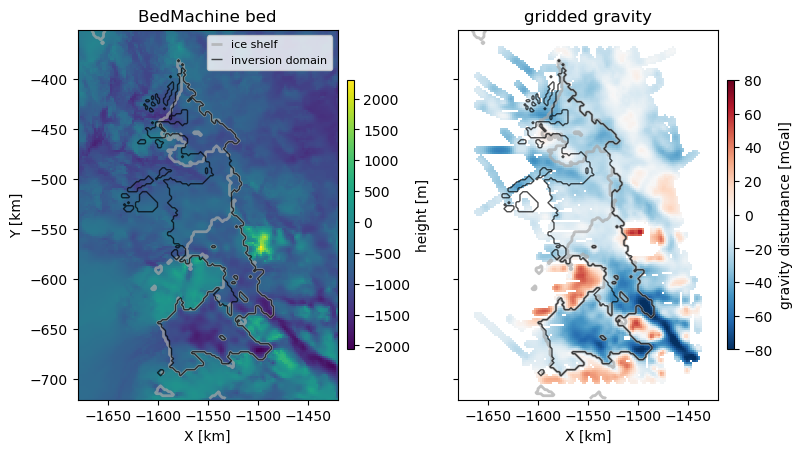

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(9,5), sharey=True)

ax = axs[0]
im = ax.pcolormesh(xkm, ykm, ds.bed_no_muto)
cs1 = ax.contour(xkm, ykm, ds.mask==3, levels=[0.5], colors='darkgrey', antialiased=True, linewidths=2, alpha=0.7)
cs2 = ax.contour(xkm, ykm, ds.inv_msk, levels=[0.5], colors='k', antialiased=True, linewidths=1, alpha=0.7)
ax.axis('scaled')
ax.set_title('BedMachine bed')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='height [m]', shrink=0.7)
handles1, _ = cs1.legend_elements()
handles2, _ = cs2.legend_elements()
ax.legend(handles1+handles2, ['ice shelf', 'inversion domain'], frameon=True, fontsize=8, handlelength=1)

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, grav_bm_grid, vmin=-80, vmax=80, cmap='RdBu_r')
ax.contour(xkm, ykm, ds.mask==3, levels=[0.5], colors='darkgray', antialiased=True, linewidths=2, alpha=0.7)
ax.contour(xkm, ykm, ds.inv_msk, levels=[0.5], colors='k', antialiased=True, linewidths=1, alpha=0.7)
ax.axis('scaled')
ax.set_title('gridded gravity')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='gravity disturbance [mGal]', shrink=0.7)

plt.show()

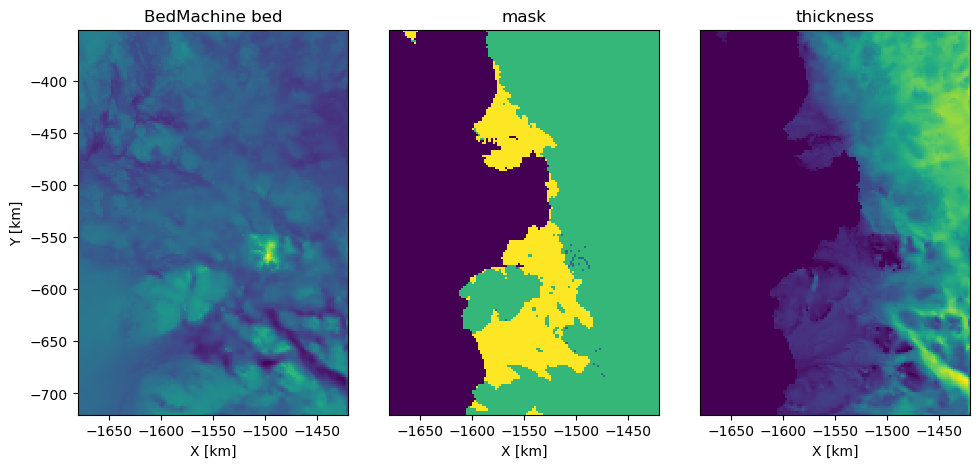

In [40]:
fig = plt.figure(figsize=(12,5))

grid = GridSpec(1, 3, wspace=0.01)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

ax1.pcolormesh(ds.x/1000, ds.y/1000, ds.bed)
ax1.set_title('BedMachine bed')
ax1.set_ylabel('Y [km]')
ax1.set_xlabel('X [km]')
ax1.axis('scaled')

ax2.pcolormesh(ds.x/1000, ds.y/1000, ds.mask)
ax2.set_title('mask')
ax2.set_xlabel('X [km]')
ax2.axis('scaled')
ax2.set_yticks([])

ax3.pcolormesh(ds.x/1000, ds.y/1000, ds.thickness)
ax3.set_title('thickness')
ax3.set_xlabel('X [km]')
ax3.axis('scaled')
ax3.set_yticks([])

plt.show()

# Bouguer interpolation

In [41]:
%%time
density_dict = {
    'ice' : 917,
    'water' : 1027,
    'rock' : 2670
}
prisms, densities = make_prisms(ds, ds.bed.values, density_dict)
len(prisms)

CPU times: total: 15.6 ms
Wall time: 7.98 ms


51188

In [42]:
%%time

pred_coords = (grav.x, grav.y, grav.height)
g_z = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')
residual = grav.faa-g_z

CPU times: total: 3min 5s
Wall time: 13.3 s


In [43]:
np.nanmax(np.abs(grav.faa)), np.nanmax(np.abs(g_z)), np.nanmax(np.abs(residual))

(np.float64(88.87996308752442),
 np.float64(100.58065652714706),
 np.float64(62.77195634890717))

In [44]:
len(grav)

12396

In [45]:
g_z_grid, residual_grid, faa_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), (g_z, residual, grav.faa.values))

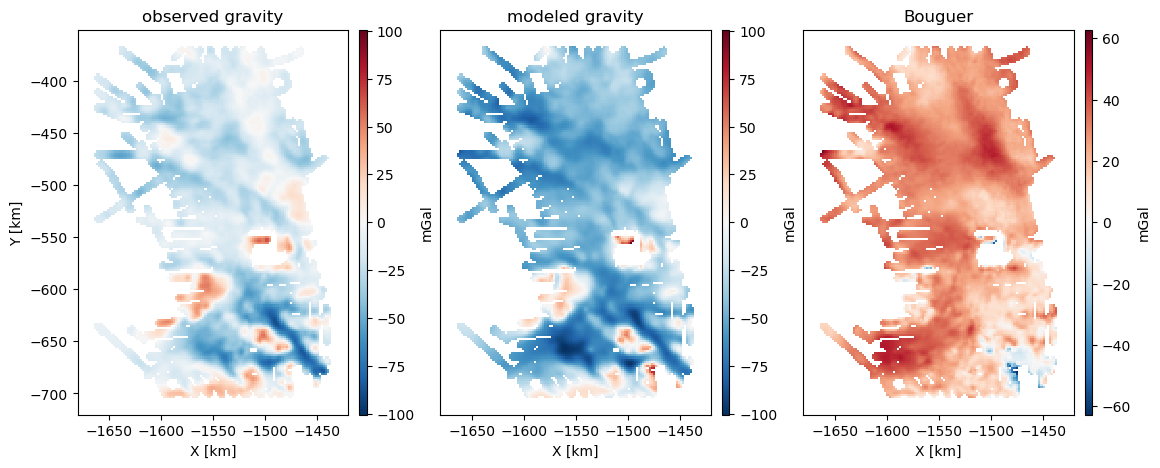

In [46]:
grav_vmax = np.nanmax(np.abs(np.concatenate([grav.faa, np.abs(g_z)])))
grav_vmin = -1*grav_vmax
res_vmax = np.nanmax(np.abs(residual))
res_vmin = -1*res_vmax
vmax = 100

fig = plt.figure(figsize=(14,5))

grid = GridSpec(1, 3, wspace=0.01)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1])
ax3 = fig.add_subplot(grid[2])

im = ax1.pcolormesh(xkm, ykm, grav_bm_grid, vmin=grav_vmin, vmax=grav_vmax, cmap='RdBu_r')
ax1.set_title('observed gravity')
ax1.set_ylabel('Y [km]')
ax1.set_xlabel('X [km]')
ax1.axis('scaled')
plt.colorbar(im, pad=0.03, aspect=50, ax=ax1, label='mGal')

im = ax2.pcolormesh(xkm, ykm, g_z_grid, vmin=grav_vmin, vmax=grav_vmax, cmap='RdBu_r')
ax2.set_title('modeled gravity')
ax2.set_xlabel('X [km]')
ax2.axis('scaled')
ax2.set_yticks([])
plt.colorbar(im, pad=0.03, aspect=50, ax=ax2, label='mGal')

im = ax3.pcolormesh(xkm, ykm, residual_grid, vmin=res_vmin, vmax=res_vmax, cmap='RdBu_r')
ax3.set_title('Bouguer')
ax3.set_xlabel('X [km]')
ax3.axis('scaled')
ax3.set_yticks([])
plt.colorbar(im, pad=0.03, aspect=50, ax=ax3, label='mGal')

plt.show()

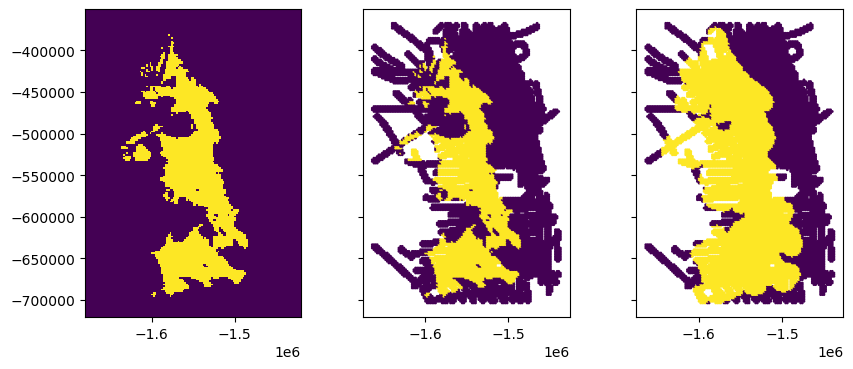

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), sharey=True)
ax1.pcolormesh(ds.x, ds.y, ds.inv_msk)
ax1.axis('scaled')

ax2.scatter(grav.x, grav.y, c=grav.inv_msk, s=1)
ax2.axis('scaled')

ax3.scatter(grav.x, grav.y, c=grav.inv_pad, s=1)
ax3.axis('scaled')
plt.show()

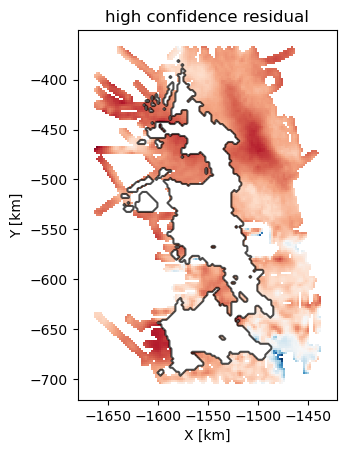

In [48]:
plt.pcolormesh(xkm, ykm, np.where(ds.inv_msk==False, residual_grid, np.nan), vmin=res_vmin, vmax=res_vmax, cmap='RdBu_r')
plt.contour(xkm, ykm, ds.inv_msk, levels=[0.5], colors='k', antialiased=True, linewidths=1.5, alpha=0.7)
plt.axis('scaled')
plt.title('high confidence residual')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

plt.show()

In [49]:
X = np.stack([grav.x[grav_inv_msk==False], grav.y[grav_inv_msk==False]]).T
y = residual[grav_inv_msk==False]
xx, yy = np.meshgrid(ds.x, ds.y)
XX = np.stack([xx.flatten(), yy.flatten()]).T

# GStatSim SGS

In [50]:
df_grid = pd.DataFrame({'X' : X[:,0], 'Y' : X[:,1], 'residual' : y})

# normal score transformation
data = df_grid['residual'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['NormZ'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['NormZ']

maxlag = 100_000             # maximum range distance
n_lags = 70                # num of bins

V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'
print(f'exp: {V1.parameters}')

V2 = deepcopy(V1)
V2.model = 'gaussian'
print(f'gaussian: {V2.parameters}')

V3 = deepcopy(V1)
V3.model = 'spherical'
print(f'spherical: {V3.parameters}')

V4 = deepcopy(V1)
V4.model = 'matern'
print(f'matern: {V4.parameters}')

# evaluate models
xi =np.linspace(0, V1.bins[-1], 100) 

y_exp = models.exponential(xi, *V1.parameters)
y_gauss = models.gaussian(xi, *V2.parameters)
y_sph = models.spherical(xi, *V3.parameters)
y_matern = models.matern(xi, *V4.parameters)

exp: [np.float64(81213.7661596995), np.float64(0.7744317278114804), 0]
gaussian: [np.float64(52822.56160333706), np.float64(0.7375714340900085), 0]
spherical: [np.float64(62933.581112029475), np.float64(0.7498387976936293), 0]
matern: [np.float64(67166.18833263796), np.float64(0.7744317278114804), np.float64(1.0089205757282422), 0]


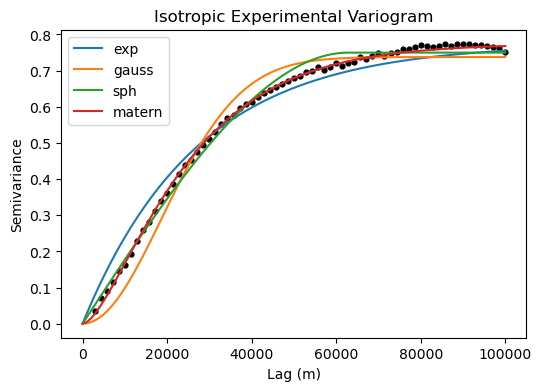

In [51]:
plt.figure(figsize=(6,4))
plt.scatter(V1.bins, V1.experimental, s=12, c='k')
plt.plot(xi, y_exp, label='exp')
plt.plot(xi, y_gauss, label='gauss')
plt.plot(xi, y_sph, label='sph')
plt.plot(xi, y_matern, label='matern')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()

plt.show()

In [52]:
# save modeled variograms
boug_model = pd.DataFrame({'x' : xi, 'exp' : y_exp, 'gauss' : y_gauss, 'sph' : y_sph, 'matern' : y_matern})
boug_model.to_csv(Path('processed_data/boug_varmodels.csv'), index=False)

# save variogram parameters
Vs = [V1, V2, V3, V4]
boug_param = pd.DataFrame({
    'h' : [V.parameters[0] for V in Vs],
    'r' : [V.parameters[1] for V in Vs],
    'c0' : [V.parameters[2] for V in Vs],
    's' : [V.parameters[3] if len(V.parameters)==4 else np.nan for V in Vs]
}, index = ['exp', 'gauss', 'sph', 'matern'])
boug_param.to_csv(Path('processed_data/boug_varparams.csv'))

# save experimental variogram
exp_model = pd.DataFrame({'bins' : V1.bins, 'exp_var' : V1.experimental})
exp_model.to_csv(Path('processed_data/boug_experimental.csv'), index=False)

### We choose the spherical covariance model

GStatSim does not yet support the Matern covariance model

In [53]:
V = V3

# set variogram parameters
azimuth = 0
nugget = V.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V.parameters[0]
minor_range = V.parameters[0]
sill = V.parameters[1]
vtype = 'spherical'

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill, vtype]

k = 20         # number of neighboring data points used to estimate a given point 
rad = 100_000    # 50 km search radius

sim = gsm.Interpolation.okrige_sgs(XX, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=False)

100%|██████████| 24050/24050 [01:53<00:00, 211.18it/s]


In [54]:
res_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), residual)

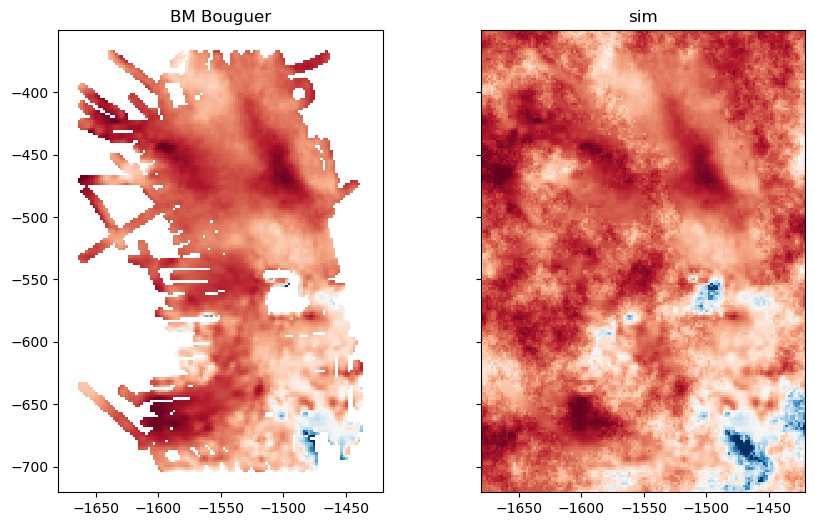

In [55]:
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1))

fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)

ax = axs[0]
ax.pcolormesh(ds.x/1000, ds.y/1000, res_grid, cmap='RdBu_r', vmin=-50, vmax=50)
ax.axis('scaled')
ax.set_title('BM Bouguer')

ax = axs[1]
ax.pcolormesh(ds.x/1000, ds.y/1000, sim_trans.reshape(xx.shape), cmap='RdBu_r', vmin=-50, vmax=50)
ax.axis('scaled')
ax.set_title('sim')
plt.show()

In [56]:
sim1 = gsm.Interpolation.okrige_sgs(XX, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=False)
sim1 = nst_trans.inverse_transform(sim1.reshape(-1,1)).reshape(xx.shape)
sim2 = gsm.Interpolation.okrige_sgs(XX, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=False)
sim2 = nst_trans.inverse_transform(sim2.reshape(-1,1)).reshape(xx.shape)

100%|██████████| 24050/24050 [01:57<00:00, 203.95it/s]


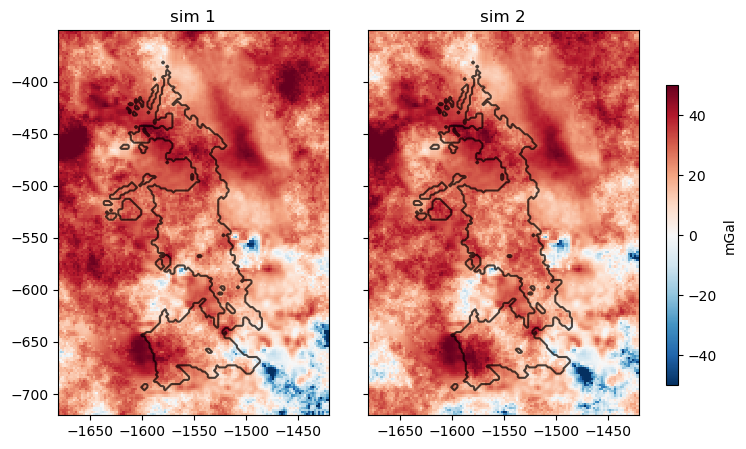

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharey=True, gridspec_kw={'wspace':0})

ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, sim1, cmap='RdBu_r', vmin=-50, vmax=50)
ax.contour(xkm, ykm, ds.inv_msk, levels=[0.5], colors='k', antialiased=True, linewidths=1.5, alpha=0.7)
ax.axis('scaled')
ax.set_title('sim 1')
#plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, sim2, cmap='RdBu_r', vmin=-50, vmax=50)
ax.contour(xkm, ykm, ds.inv_msk, levels=[0.5], colors='k', antialiased=True, linewidths=1.5, alpha=0.7)
ax.axis('scaled')
ax.set_title('sim 2')

cax = fig.add_axes([0.91, 0.17, 0.015, 0.6])
plt.colorbar(im, cax=cax, label='mGal')

plt.show()

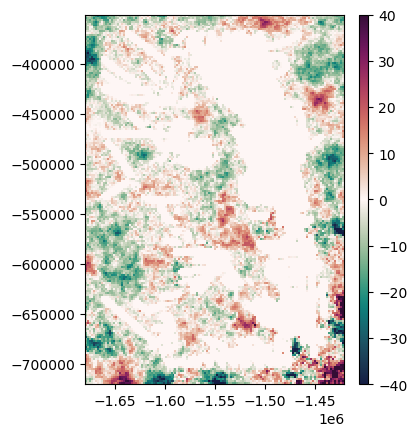

In [58]:
plt.pcolormesh(ds.x, ds.y, sim2-sim1, cmap='cmo.curl', vmin=-40, vmax=40)
plt.axis('scaled')
plt.colorbar(pad=0.03, aspect=40)
plt.show()

In [59]:
%%time

nsims = 100

param_list = []
for i in range(nsims):
    param_list.append([XX, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, True])

if __name__ == '__main__':
    pool = mp.Pool(8)
    result = pool.starmap(gsm.Interpolation.okrige_sgs, param_list)

CPU times: total: 62.5 ms
Wall time: 56min 5s


In [60]:
sims = np.zeros((nsims, *xx.shape))
for i in range(nsims):
    sims[i] = nst_trans.inverse_transform(result[i].reshape(-1,1)).reshape(xx.shape)

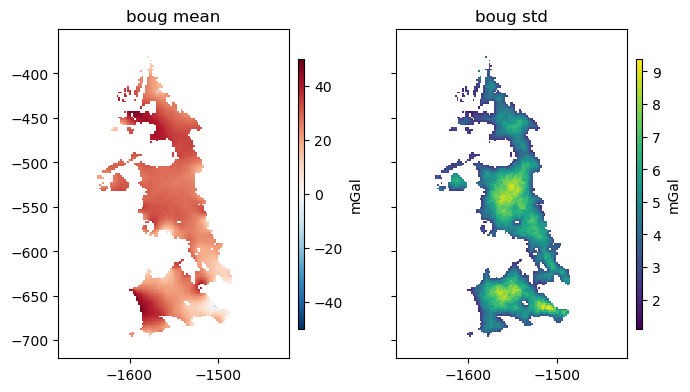

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharey=True)

ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, np.where(ds.inv_msk, np.mean(sims, axis=0), np.nan), 
                   cmap='RdBu_r', vmin=-50, vmax=50)
ax.axis('scaled')
ax.set_title('boug mean')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, shrink=0.7, label='mGal')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, np.where(ds.inv_msk, np.std(sims, axis=0), np.nan))
ax.axis('scaled')
ax.set_title('boug std')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, shrink=0.7, label='mGal')
plt.show()

In [62]:
boug_mean = np.mean(sims, axis=0)[grav_msk_grid.reshape(xx.shape)==True]
boug_std = np.std(sims, axis=0)[grav_msk_grid.reshape(xx.shape)==True]
te_mean = grav.faa-boug_mean

### Filtering SGS

In [63]:
%%time

target0 = boug_interpolation_sgs(ds, grav, 2670)
boug_filt0 = filter_boug(ds, grav, target0, 8e3, 0)

CPU times: total: 11min 28s
Wall time: 1min 33s


In [64]:
target0.shape, boug_filt0.shape

((12396,), (12396,))

In [65]:
target_filt0 = grav.faa.values - boug_filt0

In [66]:
target0_grid, target_filt0_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), (target0, target_filt0))

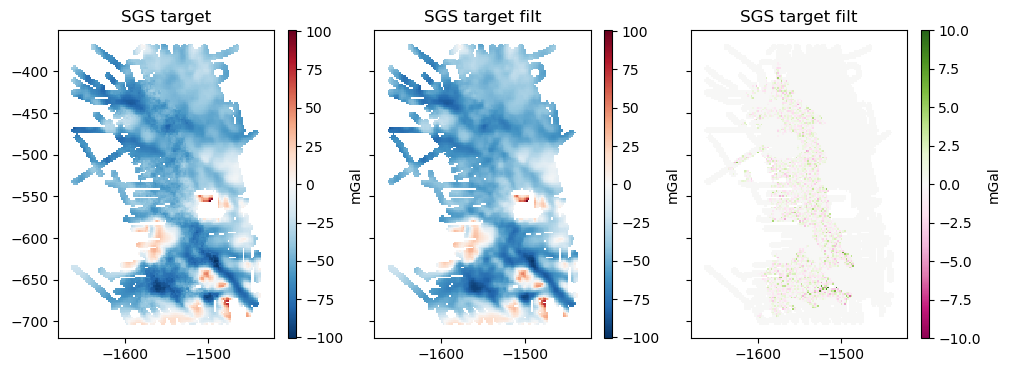

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True, gridspec_kw=dict(wspace=-0.3))

ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, target0_grid, vmin=grav_vmin, vmax=grav_vmax, cmap='RdBu_r')
ax.axis('scaled')
ax.set_title('SGS target')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, target_filt0_grid, vmin=grav_vmin, vmax=grav_vmax, cmap='RdBu_r')
ax.axis('scaled')
ax.set_title('SGS target filt')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')

ax = axs[2]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, target0_grid-target_filt0_grid, vmin=-10, vmax=10, cmap='PiYG')
ax.axis('scaled')
ax.set_title('SGS target filt')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')
plt.show()

In [68]:
%%time

nsims = 100

param_list = []
for i in range(nsims):
    param_list.append([ds, grav, 2670, 12e3, 0])

if __name__ == '__main__':
    pool = mp.Pool(8)
    result = pool.starmap(sgs_filt, param_list)

CPU times: total: 281 ms
Wall time: 1h 23min 18s


In [69]:
sims_filt = np.array(result)
sims_filt.shape

(100, 12396)

In [70]:
sims_filt_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), sims_filt)
sims_filt_grid = np.array(sims_filt_grid)
sims_filt_grid.shape

(100, 185, 130)

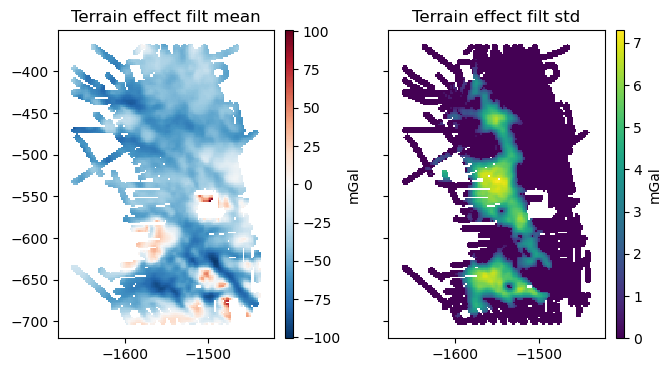

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True, gridspec_kw=dict(wspace=-0.1))

ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, np.mean(sims_filt_grid, axis=0), cmap='RdBu_r', vmin=grav_vmin, vmax=grav_vmax)
ax.axis('scaled')
ax.set_title('Terrain effect filt mean')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, np.std(sims_filt_grid, axis=0), vmin=0)
ax.axis('scaled')
ax.set_title('Terrain effect filt std')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')
plt.show()

In [72]:
boug_mean_grid, boug_std_grid, te_mean_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), (boug_mean, boug_std, te_mean))

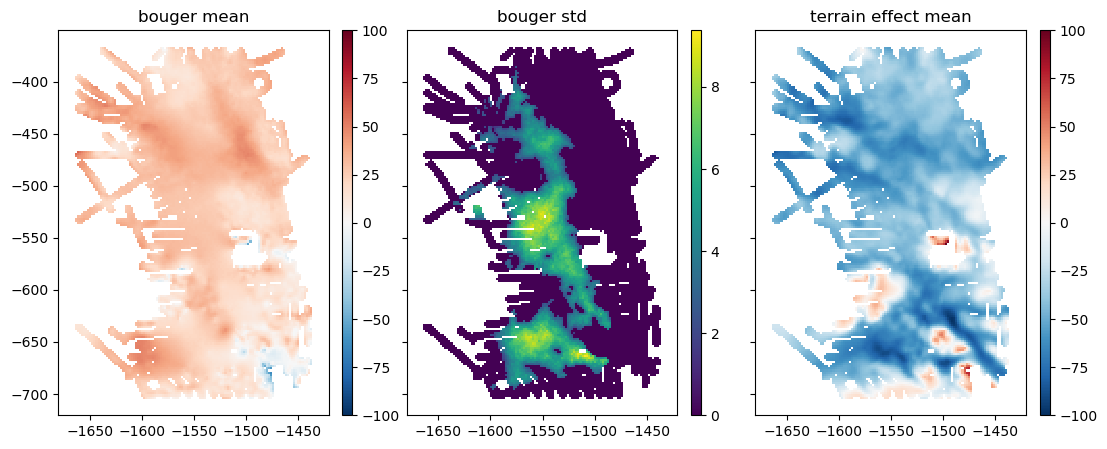

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True, gridspec_kw={'wspace':-0.25})

ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, boug_mean_grid, cmap='RdBu_r', vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('bouger mean')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, boug_std_grid)
ax.axis('scaled')
ax.set_title('bouger std')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, te_mean_grid, cmap='RdBu_r', vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('terrain effect mean')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

In [74]:
sims.shape

(100, 185, 130)

In [75]:
np.save(Path(f'processed_data/boug_sims_{res}.npy'), sims)
np.save(Path(f'processed_data/target_filt_{res}.npy'), sims_filt_grid)

In [76]:
grav['msk'] = grav_msk
grav['inv_msk'] = grav_inv_msk
grav['boug_mean'] = boug_mean
grav['boug_std'] = boug_std
grav['te_mean'] = te_mean

# save gravity
grav.to_csv(Path(f'processed_data/grav_leveled_{res}.csv'), index=False)

## Kriging for comparison to SGS mean and std

In [77]:
est_OK, var_OK = gsm.Interpolation.okrige(XX, df_grid, 'X', 'Y', 'NormZ', 64, vario, 500e3, True)

# reverse normal score transformation
var_OK[var_OK < 0] = 0      # make sure variances are non-negative
std_OK = np.sqrt(var_OK)    # convert to standard deviation before back transforming

# reshape
est = est_OK.reshape(-1,1)
std = std_OK.reshape(-1,1)

# back transformation
spred_trans = nst_trans.inverse_transform(est)
sstd_trans = nst_trans.inverse_transform(std)
sstd_trans = sstd_trans - np.min(sstd_trans)

spred_trans = spred_trans.reshape(xx.shape)
sstd_trans = sstd_trans.reshape(xx.shape)

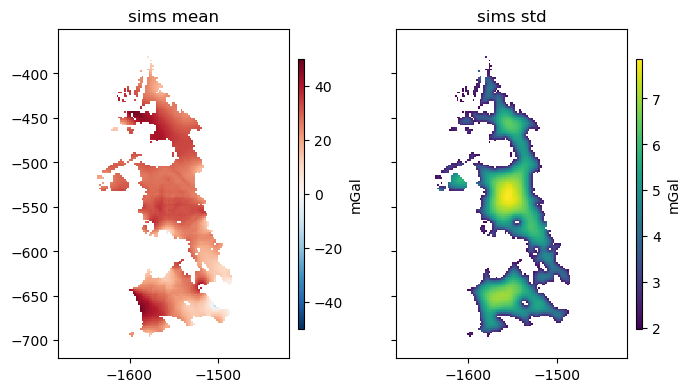

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharey=True)

ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, np.where(ds.inv_msk, spred_trans, np.nan), 
                   cmap='RdBu_r', vmin=-50, vmax=50)
ax.axis('scaled')
ax.set_title('sims mean')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, shrink=0.7, label='mGal')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, np.where(ds.inv_msk, sstd_trans, np.nan))
ax.axis('scaled')
ax.set_title('sims std')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, shrink=0.7, label='mGal')
plt.show()

# Removing extra prisms

In [79]:
pred_coords = (grav.x, grav.y, grav.height)

In [80]:
%%time
prisms, densities = make_prisms(ds, ds.bed.data, density_dict)
print(prisms.shape)

g_z_all = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')

(51188, 6)
CPU times: total: 4min 44s
Wall time: 20.1 s


In [81]:
%%time
prisms, densities = make_prisms(ds, ds.bed.data, density_dict, msk=ds.inv_msk.values)
print(prisms.shape)

g_z_inv = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')

(10684, 6)
CPU times: total: 1min 5s
Wall time: 4.5 s


In [82]:
%%time
prisms, densities = make_prisms(ds, ds.bed.data, density_dict, msk=~ds.inv_msk.values)
print(prisms.shape)

g_z_no_inv = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')

(40504, 6)
CPU times: total: 3min 40s
Wall time: 15.8 s


In [83]:
g_z_grids = xy_into_grid(ds, (grav.x.values, grav.y.values), (g_z_all, g_z_inv, g_z_no_inv))

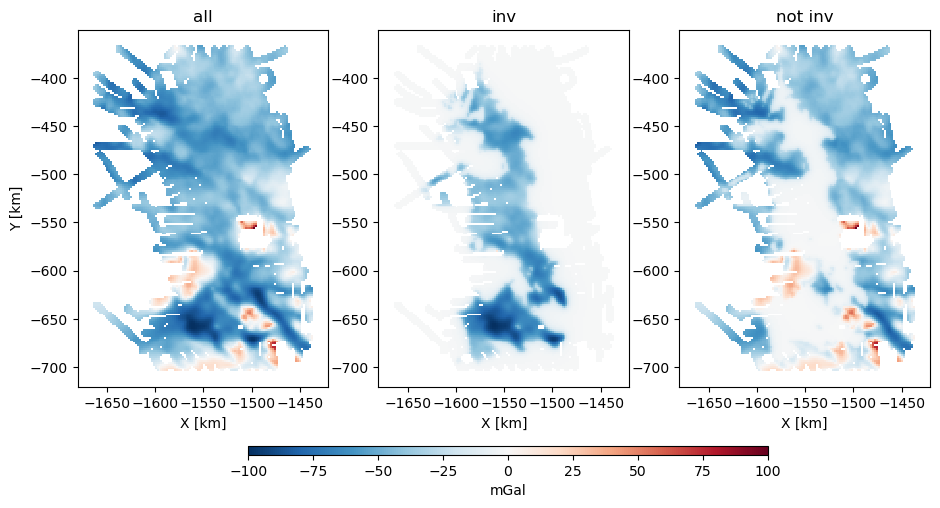

In [84]:
titles = ['all', 'inv', 'not inv']

fig = plt.figure(figsize=(11,6))
gs = GridSpec(2, 3, height_ratios=[1, 0.02], hspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
axs = [ax1, ax2, ax3]

#fig, axs = plt.subplots(1, 4, figsize=(12,4), sharey=True)

for ax, g_z_grid_i, title in zip(axs, g_z_grids, titles):
    im = ax.pcolormesh(ds.x/1000, ds.y/1000, g_z_grid_i, vmin=-100, vmax=100, cmap='RdBu_r' )
    ax.axis('scaled')
    ax.set_title(title)
    ax.set_xlabel('X [km]')

gs2 = GridSpecFromSubplotSpec(1, 100, gs[1,:])
cax = fig.add_subplot(gs2[20:81])
plt.colorbar(im, cax=cax, orientation='horizontal', label='mGal', shrink=0.65)

axs[0].set_ylabel('Y [km]')
plt.show()

In [85]:
%%time
prisms, densities = make_prisms(ds, ds.bed.data, density_dict, ice=True)
print(prisms.shape)

g_z_ice = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')

(51188, 6)
CPU times: total: 4min 47s
Wall time: 20.2 s


In [86]:
%%time
prisms, densities = make_prisms(ds, ds.bed.data, density_dict, ice=False)
print(prisms.shape)

g_z_no_ice = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')

(23979, 6)
CPU times: total: 1min 38s
Wall time: 7.09 s


In [87]:
g_z_ice_grid, g_z_no_ice_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), (g_z_ice, g_z_no_ice))

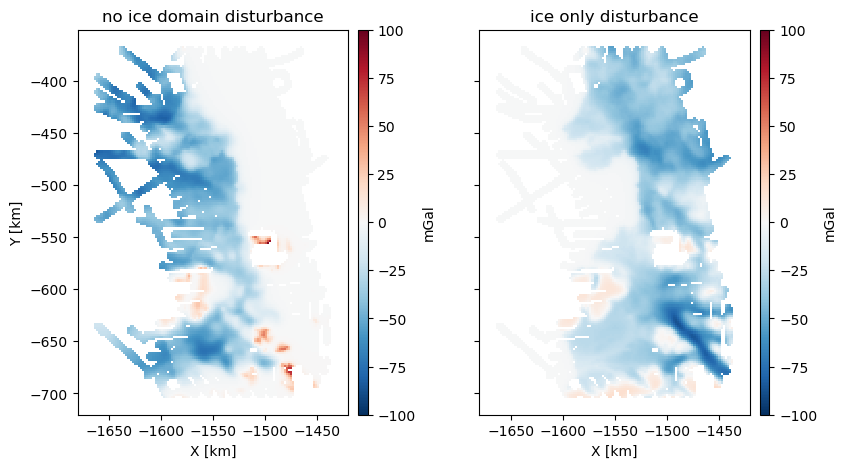

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(9.5,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, g_z_no_ice_grid, vmin=-100, vmax=100, cmap='RdBu_r')
ax.axis('scaled')
ax.set_title('no ice domain disturbance')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, pad=0.03, aspect=40, label='mGal')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, g_z_ice_grid-g_z_no_ice_grid, vmin=-100, vmax=100, cmap='RdBu_r')
ax.axis('scaled')
ax.set_title('ice only disturbance')
ax.set_xlabel('X [km]')
plt.colorbar(im, pad=0.03, aspect=40, label='mGal')
plt.show()

## Covariance matrix that reproduces variogram

This covariance model will be used to generate random fields to perturb the bed in the MCMC

In [89]:
def gauss_cov(bsize, corr_dist):
    bi, bj = np.meshgrid(np.arange(bsize), np.arange(bsize))
    X_b = np.stack([bi.flatten(), bj.flatten()]).T
    D = pairwise_distances(X_b)**2
    cov_eps = 1e-10
    return np.exp(-D/(0.5*corr_dist)**2) + np.diag(np.full(D.shape[0], cov_eps))

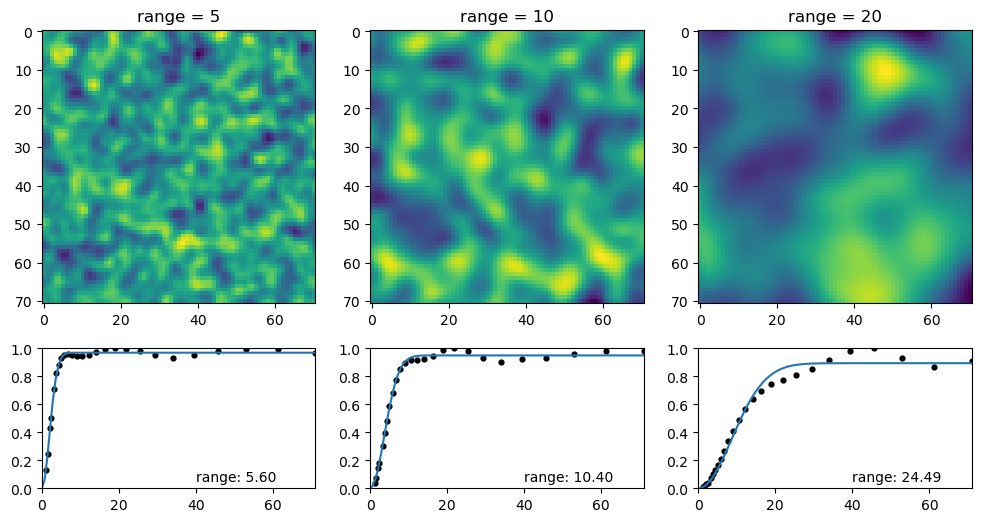

In [90]:
bsize = 71

ranges = [5, 10, 20]

maxlag = bsize             # maximum range distance
n_lags = 30                # num of bins

xy = np.arange(0, bsize)
xx_tmp, yy_tmp = np.meshgrid(xy, xy)
coords = np.array([xx_tmp.flatten(), yy_tmp.flatten()]).T

fig, axs = plt.subplots(2, 3, figsize=(12,6), gridspec_kw=dict(height_ratios=[1,0.5]))

axs1 = axs[0,:]
axs2 = axs[1,:]

for rangei, ax1, ax2 in zip(ranges, axs1, axs2):
    var = 60
    
    Sigma = gauss_cov(bsize, rangei)
    
    rng = np.random.default_rng()
    sample = rng.multivariate_normal(np.zeros(Sigma.shape[0]), Sigma, size=1, method='cholesky')*var/3
    sample = sample.reshape((bsize, bsize))

    ax1.imshow(sample)
    ax1.set_title(f'range = {rangei}')

    V1 = skg.Variogram(coords, sample.flatten(), bin_func=np.geomspace(1, 71, n_lags), n_lags=n_lags, 
                       maxlag=maxlag, normalize=True, model='gaussian')

    ax2.scatter(V1.bins, V1.experimental/np.nanmax(V1.experimental), s=12, c='k')
    ax2.set_xlim(0, bsize)
    ax2.set_ylim(0, 1)

    xi =np.linspace(0, V1.bins[-1], 100)
    y_gauss = skg.models.gaussian(xi, *V1.parameters)/np.nanmax(V1.experimental)
    ax2.plot(xi, y_gauss)

    ax2.annotate(f'range: {V1.parameters[0]:.2f}', (40,0.05))

plt.show()